In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import bioframe as bf
import numpy as np
from pybedtools import BedTool
import re
import seaborn as sns



import matplotlib
import os


figure_width = 5
matplotlib.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure2/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    matplotlib.rcParams.update(new_rc_params)


In [2]:
gm_df = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep = '\t')
im_df = pd.read_csv('../annotations/IMR90_hg38_25kb.tsv', sep = '\t')

In [3]:
chrom_hmm_dir = '/pollard/data/wynton/consortia/roadmap/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final'

In [4]:
gm_chrom =  chrom_hmm_dir+'/E116_15_coreMarks_hg38lift_dense.bed.gz'
im_chrom =  chrom_hmm_dir+'/E017_15_coreMarks_hg38lift_dense.bed.gz'


In [9]:
gm_chrom_df = BedTool(gm_chrom).to_dataframe(skiprows=1)
im_chrom_df = BedTool(im_chrom).to_dataframe(skiprows=1)

In [12]:
def bedtools_intersect_basePairs(left, right):

    out = bf.overlap(left, right, return_overlap=True)
    out['bpOverlap'] = out['overlap_end'] - out['overlap_start']
    out = out.drop(columns=['overlap_end', 'overlap_start'])    
    return out

In [13]:
gm_inter = bedtools_intersect_basePairs(gm_df, gm_chrom_df)
im_inter = bedtools_intersect_basePairs(im_df, im_chrom_df)

In [89]:
def overlap_matrix(inter_df, segmentation, chrom_states):
    mask = inter_df.E1.isna() | inter_df.start_.isna()
    inter_df = inter_df[~mask]
        
    n_states = inter_df[segmentation].unique()
    n_states = sorted(n_states)
    
    total_mat = list()
    for chrom_state in chrom_states:
        state_scores = list()
        for state in n_states:
            mask = (inter_df[segmentation]==state) & (inter_df.name_ == chrom_state)
            score = inter_df.loc[mask, 'bpOverlap'].sum()
            state_scores.append(score)
        
        total_mat.append(state_scores)
        
    return np.array(total_mat)

In [96]:
chrom_states = list(gm_chrom_df.name.unique())
chrom_states = sorted(chrom_states, key=lambda x:int(re.findall('[0-9]+', x)[0]))
hmm_states = ['B', 'Mbb', 'M', 'Maa', 'A']

In [165]:
segmentation = 'HMM3P'
gm_mat = overlap_matrix(gm_inter, segmentation=segmentation, chrom_states=chrom_states)
gm_expected = np.outer(gm_mat.sum(axis=1), gm_mat.sum(axis=0))/gm_mat.sum()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


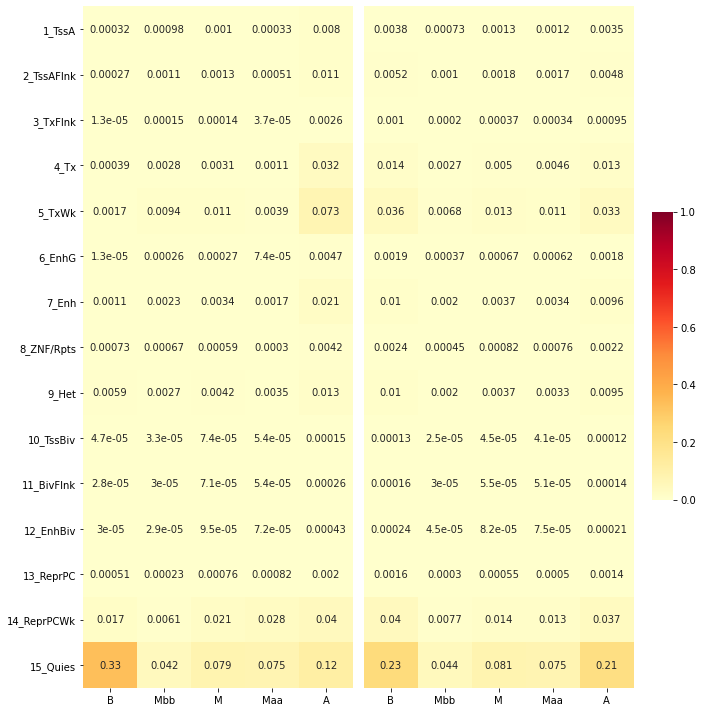

In [166]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(10, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(gm_mat/gm_mat.sum(), ax= ax1, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar=False)

sns.heatmap(gm_expected/gm_mat.sum(), ax=ax2, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=False,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .5}, cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

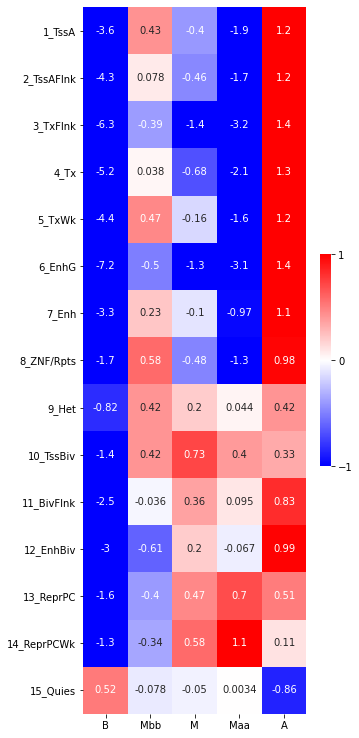

In [170]:
plt.figure(figsize =(5, 13))
sns.heatmap(np.log2(gm_mat/gm_expected), annot=True, cmap='bwr', vmin=-1, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .3, "ticks":[-1, 0, 1]})

if saveFigs:
    plt.savefig(figure_path+'GM12878_ChromHMM_'+segmentation+'.svg', bbox_inches='tight')

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


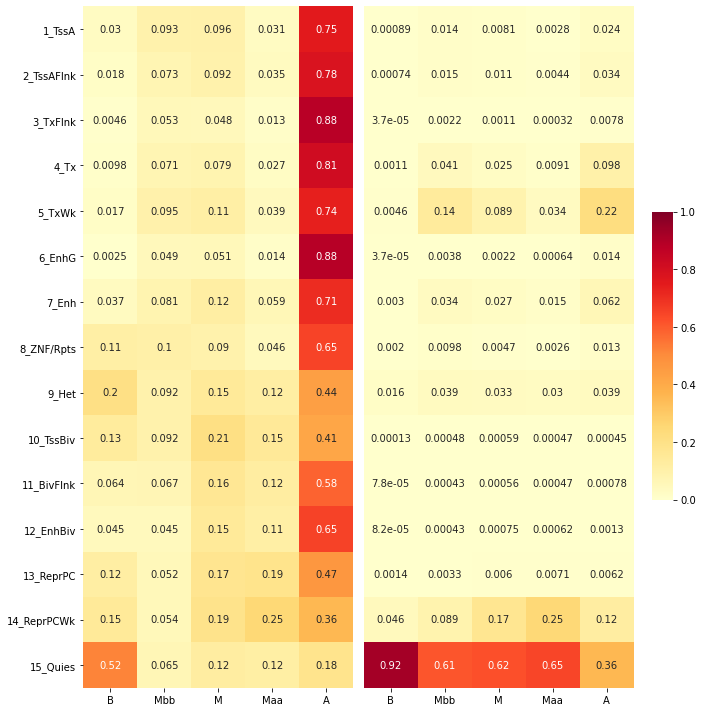

In [174]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(10, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(gm_mat/gm_mat.sum(axis=1,keepdims=True), ax= ax1, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar=False)

sns.heatmap(gm_mat/gm_mat.sum(axis=0,keepdims=True), ax=ax2, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=False,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .5}, cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
if saveFigs:
    plt.savefig(figure_path+'GM12878_ChromHMM_percentages_'+segmentation+'.svg', bbox_inches='tight')

In [145]:
im_mat = overlap_matrix(im_inter, segmentation=segmentation, chrom_states=chrom_states)
im_expected = np.outer(im_mat.sum(axis=1), im_mat.sum(axis=0))/im_mat.sum()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


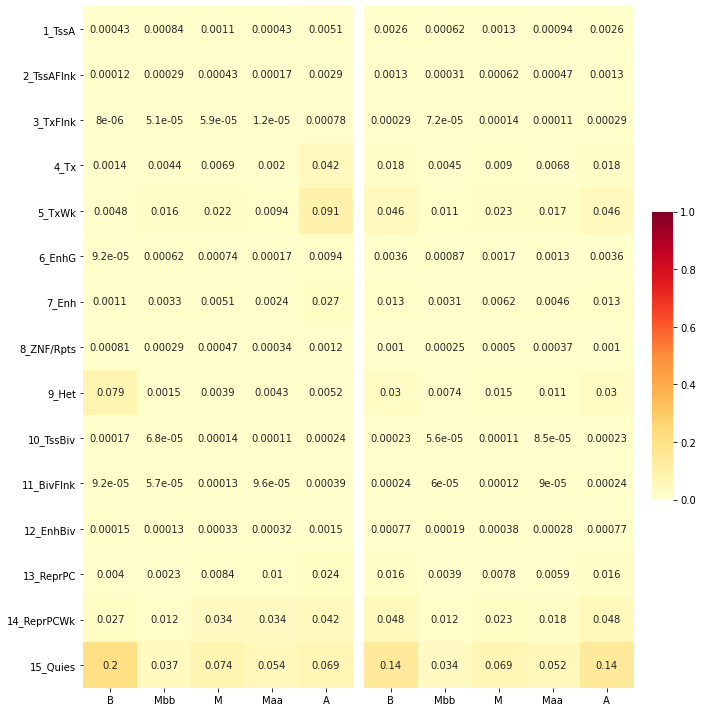

In [147]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(10, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(im_mat/im_mat.sum(), ax= ax1, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar=False)

sns.heatmap(im_expected/im_mat.sum(), ax=ax2, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=False,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .5}, cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

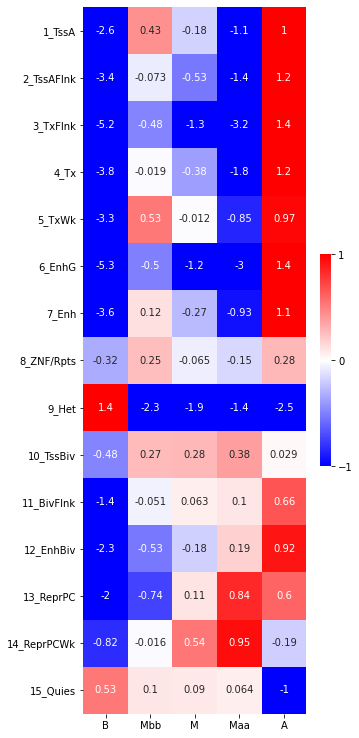

In [172]:
plt.figure(figsize =(5, 13))
sns.heatmap(np.log2(im_mat/im_expected), annot=True, cmap='bwr', vmin=-1, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .3, "ticks":[-1, 0, 1]})
if saveFigs:
    plt.savefig(figure_path+'IMR90_ChromHMM_'+segmentation+'.svg', bbox_inches='tight')

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


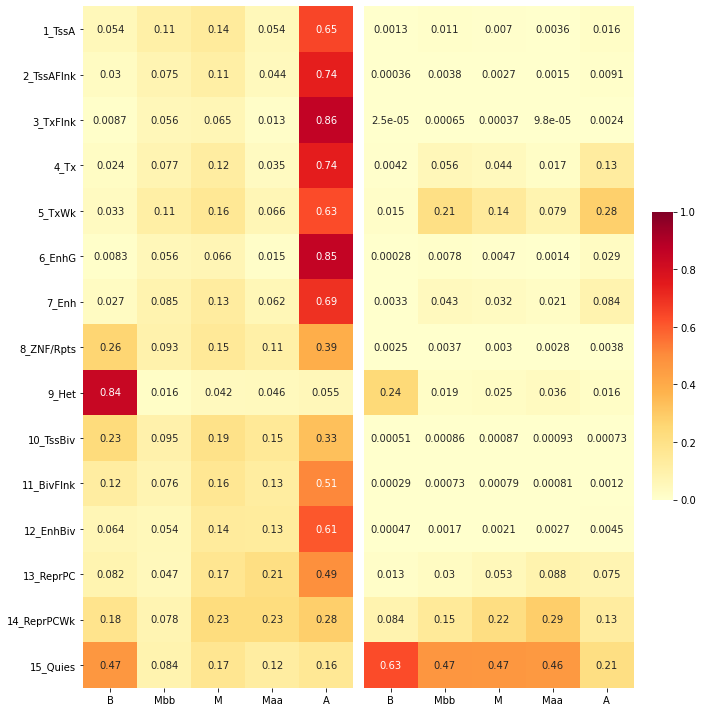

In [173]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(10, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(im_mat/im_mat.sum(axis=1,keepdims=True), ax= ax1, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=hmm_states,
            cbar=False)

sns.heatmap(im_mat/im_mat.sum(axis=0,keepdims=True), ax=ax2, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=False,
            xticklabels=hmm_states,
            cbar_kws={"shrink": .5}, cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
if saveFigs:
    plt.savefig(figure_path+'IMR90_ChromHMM_percentages_'+segmentation+'.svg', bbox_inches='tight')

In [191]:
binsize = 1000
assembly='hg38'
chromsizes = bf.fetch_chromsizes(assembly)
chrombins = bf.binnify(chromsizes[:22], binsize=binsize)
chrombins

,chrom,start,end
0,chr1,0,1000
1,chr1,1000,2000
2,chr1,2000,3000
3,chr1,3000,4000
4,chr1,4000,5000
...,...,...,...
2875007,chr22,50814000,50815000
2875008,chr22,50815000,50816000
2875009,chr22,50816000,50817000
2875010,chr22,50817000,50818000


In [210]:
gm_im_df = bf.overlap(gm_chrom_df, im_chrom_df, return_overlap=True)
gm_im_df['bpOverlap'] = gm_im_df['overlap_end'] - gm_im_df['overlap_start']

In [217]:
def sorted_names(bed_df, name):
    unique_names = list(bed_df[name].unique())
    unique_names = sorted(unique_names, key=lambda x:int(re.findall('[0-9]+', x)[0]))
    return unique_names

In [220]:
def overlap_matrix_bed(inter_df):
    mask = inter_df.name.isna() | inter_df.name_.isna()
    inter_df = inter_df[~mask]
    
    states_1 = sorted_names(inter_df, 'name')
    states_2 = sorted_names(inter_df, 'name_')
        
    total_mat = list()
    for s1 in states_1:
        state_scores = list()
        for s2 in states_2:
            mask = (inter_df.name == s1) & (inter_df.name_ == s2)
            score = inter_df.loc[mask, 'bpOverlap'].sum()
            state_scores.append(score)
        
        total_mat.append(state_scores)
        
    return np.array(total_mat)

In [227]:
gm_im_mat = overlap_matrix_bed(gm_im_df)

In [228]:
gm_im_mat_expected = np.outer(gm_im_mat.sum(axis=1), gm_im_mat.sum(axis=0))/gm_im_mat.sum()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


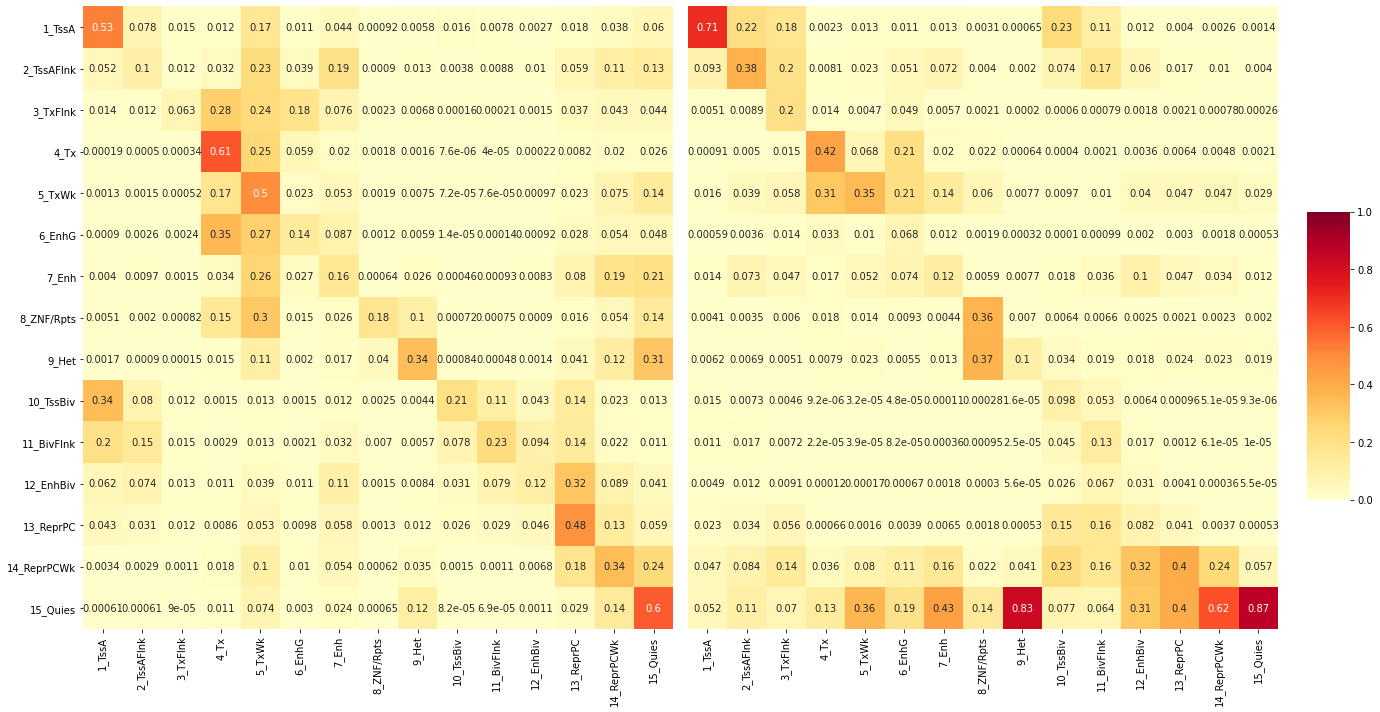

In [229]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(20, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(gm_im_mat/gm_im_mat.sum(axis=1,keepdims=True), ax= ax1, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=chrom_states,
            xticklabels=chrom_states,
            cbar=False)

sns.heatmap(gm_im_mat/gm_im_mat.sum(axis=0,keepdims=True), ax=ax2, annot=True, cmap='YlOrRd', vmin=0, vmax=1, 
            yticklabels=False,
            xticklabels=chrom_states,
            cbar_kws={"shrink": .5}, cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

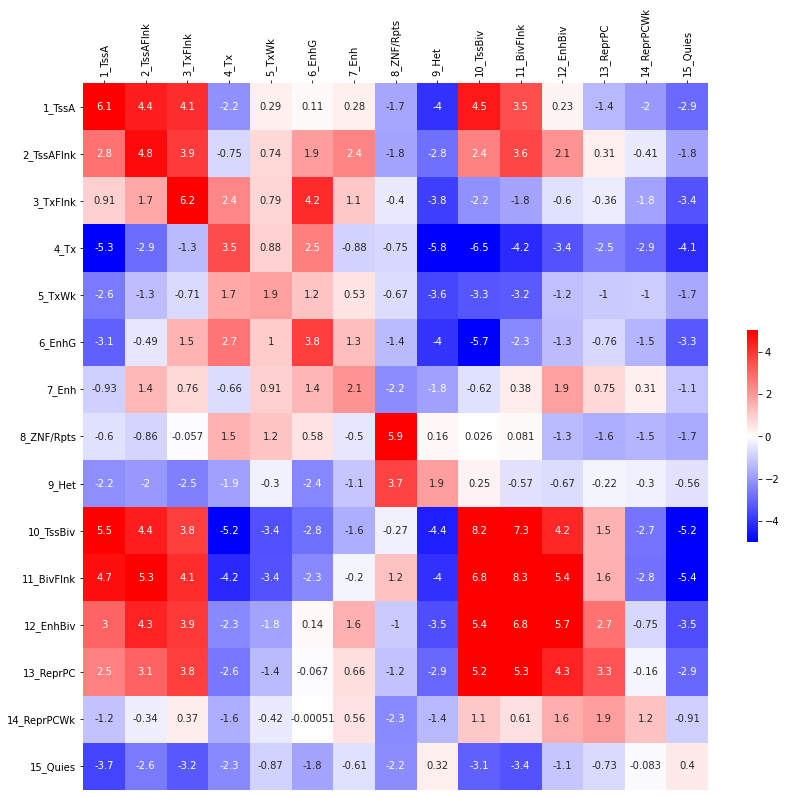

In [245]:
plt.figure(figsize =(14, 13))
sns.heatmap(np.log2(gm_im_mat/gm_im_mat_expected), annot=True, cmap='bwr', vmin=-5, vmax=5, 
            yticklabels=chrom_states,
            xticklabels=chrom_states,
            cbar_kws={"shrink": .3})

plt.gca().xaxis.set_ticks_position("top")
plt.xticks(rotation=90);

In [253]:
np.round(gm_im_mat.sum(axis=1)[8]*100/gm_im_mat.sum(),2)

2.84

In [252]:
np.round(gm_im_mat.sum(axis=0)[8]*100/gm_im_mat.sum(),2)

9.2

In [27]:
# gm_rao_df = BedTool('/pollard/home/lchumpitaz/Hi-C/testing/Rao_calls/GSE63525_GM12878_subcompartments.bed.gz').to_dataframe(skiprows=1)
# rao_inter = bedtools_intersect_basePairs(gm_df, gm_rao_df)
# rao_states = gm_rao_df.name.unique()
# rao_states  = rao_states[rao_states==rao_states]
# rao_states.sort()
# rao_percentages = get_chrom_percentages(rao_inter, gm_df, hmm_states, rao_states)
# rao_scores = get_chrom_scores(rao_inter,gm_df, hmm_states, rao_states)


In [28]:
# score_heatmap(rao_percentages, hmm_states, rao_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [29]:
#score_heatmap(rao_scores, hmm_states, rao_states)

In [30]:
# rao_chrom_inter = bedtools_intersect_basePairs(gm_rao_df, gm_chrom_df)
# rao_chrom_inter.rename(columns={'name':'states', 'name_':'name'}, inplace=True)
# rao_chrom_percentages = get_chrom_percentages(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states')
# rao_chrom_percentages_c = get_chrom_percentages(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states', column=True)

In [31]:
# score_heatmap(rao_chrom_percentages, rao_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [32]:
# score_heatmap(rao_chrom_percentages_c, rao_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [33]:
# gm_rao_df.rename(columns={'name':'states'}, inplace=True)
# rao_chrom_scores = get_chrom_scores(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states')

In [34]:
# score_heatmap(rao_chrom_scores, rao_states, chrom_states)